Prokash Chandra Roy

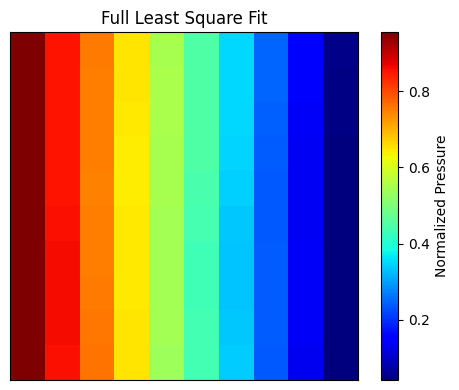

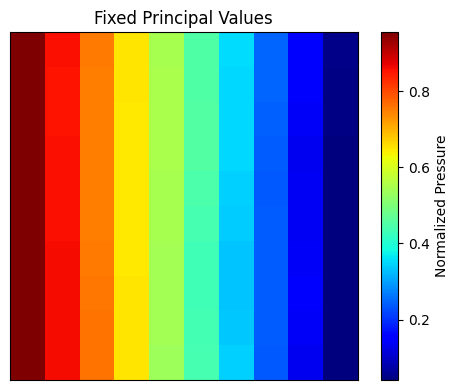

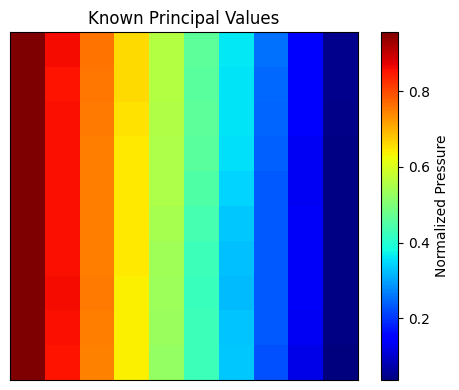

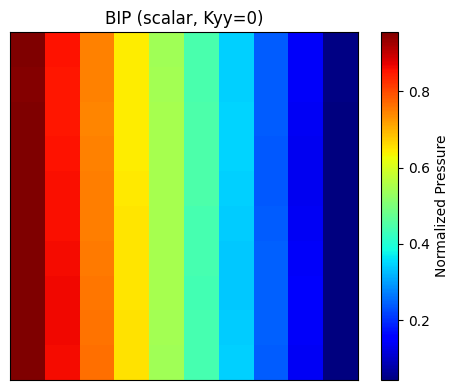

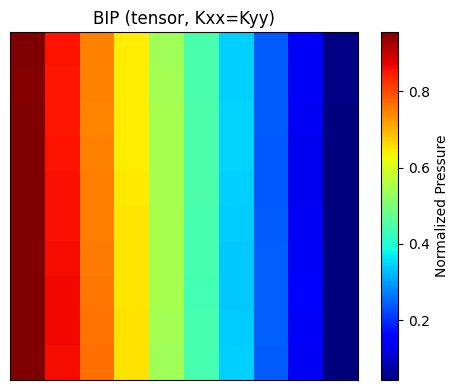


=== LBM Normalization Check ===
LBM min=0.99988, max=1.05015, valid=3960000 / 6553600



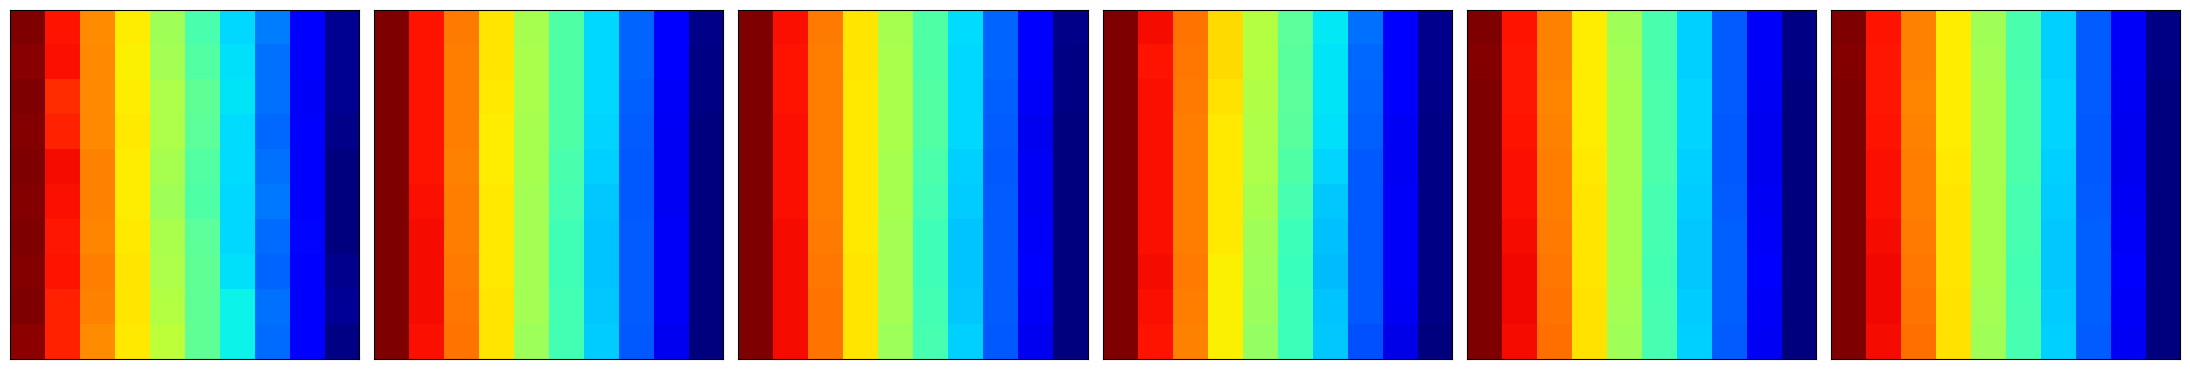

RMSE(LBM, Full Least Square Fit): 1.167506e-02
MAE (LBM, Full Least Square Fit): 8.672235e-03

RMSE(LBM, Fixed Principal Values): 1.166513e-02
MAE (LBM, Fixed Principal Values): 8.614909e-03

RMSE(LBM, Known Principal Values): 1.521170e-02
MAE (LBM, Known Principal Values): 1.100251e-02

RMSE(LBM, BIP (scalar, Kyy=0)): 1.083399e-02
MAE (LBM, BIP (scalar, Kyy=0)): 8.067606e-03

RMSE(LBM, BIP (tensor, Kxx=Kyy)): 1.083399e-02
MAE (LBM, BIP (tensor, Kxx=Kyy)): 8.067606e-03



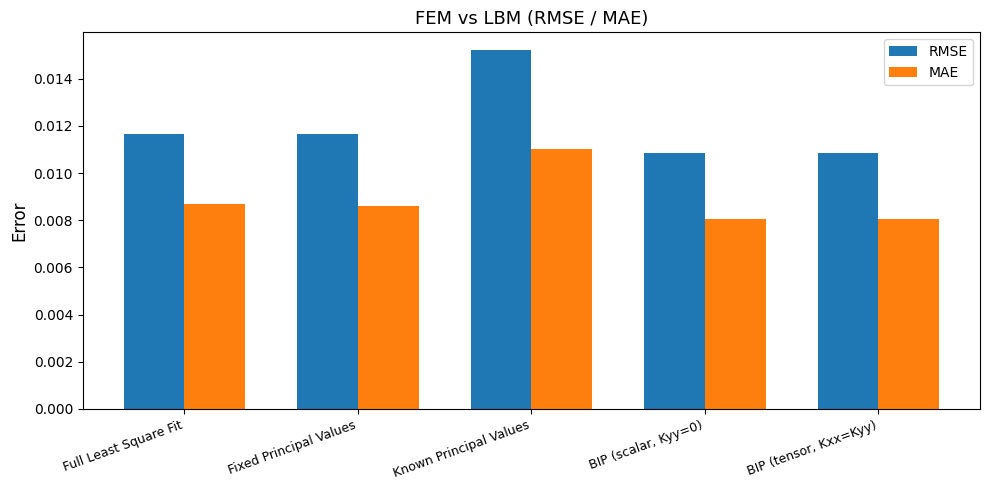

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os

# ============================================================
#  Helper Functions
# ============================================================
def local_stiffness(coords, K):
    x, y = coords[:, 0], coords[:, 1]
    area = 0.5 * abs((x[1]-x[0])*(y[2]-y[0]) - (x[2]-x[0])*(y[1]-y[0]))
    B = np.array([
        [y[1]-y[2], y[2]-y[0], y[0]-y[1]],
        [x[2]-x[1], x[0]-x[2], x[1]-x[0]]
    ]) / (2 * area)
    return area * B.T @ K @ B

def assemble_and_solve(K_tensor, Nx, Ny):
    """Assemble FEM system and solve for nodal pressures."""
    num_nodes_x, num_nodes_y = Nx + 1, Ny + 1
    num_nodes = num_nodes_x * num_nodes_y
    hx, hy = 1.0 / Nx, 1.0 / Ny
    nodes = np.array([[i*hx, j*hy] for j in range(num_nodes_y) for i in range(num_nodes_x)])

    elements = []
    for j in range(Ny):
        for i in range(Nx):
            n0 = j*(Nx+1)+i
            n1, n2, n3 = n0+1, n0+Nx+1, n0+Nx+2
            elements += [[n0,n1,n3],[n0,n3,n2]]

    K_global = sp.lil_matrix((num_nodes, num_nodes))
    F_global = np.zeros(num_nodes)

    for el in elements:
        coords = nodes[el]
        i_center = int(np.mean([el[0]%(Nx+1), el[1]%(Nx+1), el[2]%(Nx+1)]))
        j_center = int(np.mean([el[0]//(Nx+1), el[1]//(Nx+1), el[2]//(Nx+1)]))
        K = K_tensor[i_center, j_center]
        Ke = local_stiffness(coords, K)
        for a in range(3):
            for b in range(3):
                K_global[el[a], el[b]] += Ke[a, b]

    # Dirichlet BCs
    P = np.full(num_nodes, np.nan)
    bc_left  = [i for i in range(num_nodes) if np.isclose(nodes[i,0],0.0)]
    bc_right = [i for i in range(num_nodes) if np.isclose(nodes[i,0],1.0)]
    P[bc_left], P[bc_right] = 1.05, 1.0

    free, fixed = np.where(np.isnan(P))[0], np.where(~np.isnan(P))[0]
    F_mod = F_global[free] - K_global[free][:,fixed] @ P[fixed]
    K_mod = K_global[free][:,free].tocsc()
    P[free] = spla.spsolve(K_mod, F_mod)
    return P.reshape((num_nodes_y, num_nodes_x))

def normalize_and_average(field):
    """Replace NaN→0, then normalize 0–1, then average to 10×10."""
    field = np.nan_to_num(field)
    fmin, fmax = field.min(), field.max()
    norm = (field - fmin) / (fmax - fmin + 1e-12)
    avg = 0.25 * (norm[:-1,:-1] + norm[1:,:-1] + norm[:-1,1:] + norm[1:,1:])
    return avg

def plot_field(field, title, filename):
    plt.figure(figsize=(5,4))
    plt.imshow(field, origin='lower', cmap='jet')
    plt.title(title)
    plt.xticks([]); plt.yticks([])
    plt.colorbar(label="Normalized Pressure")
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

def compute_rmse(a,b):
    mask = ~np.isnan(a) & ~np.isnan(b)
    return np.sqrt(mean_squared_error(a[mask], b[mask]))

def compute_mae(a,b):
    mask = ~np.isnan(a) & ~np.isnan(b)
    return mean_absolute_error(a[mask], b[mask])

# ============================================================
#  Load Permeability Data
# ============================================================
df = pd.read_csv("predicted_permeabilities.csv")
Nx = Ny = 10
results = {}

# ============================================================
# Full Least Square Fit (FLSF)
# ============================================================
K_tensor_flsf = np.zeros((Nx,Ny,2,2))
for i in range(Nx):
    for j in range(Ny):
        tile = f"tile_r{i+1}_c{j+1}.tiff"
        tdf = df[df["image_name"]==tile]
        theta = np.deg2rad(tdf["target_angle"].values)
        k_vals = tdf["predicted_perm"].values
        A = np.column_stack([np.cos(theta)**2, np.sin(theta)**2, 2*np.sin(theta)*np.cos(theta)])
        Kxx,Kyy,Kxy = np.linalg.lstsq(A,k_vals,rcond=None)[0]
        K_tensor_flsf[i,j] = [[Kxx,Kxy],[Kxy,Kyy]]
P = assemble_and_solve(K_tensor_flsf,Nx,Ny)
results["Full Least Square Fit"] = normalize_and_average(P)

# ============================================================
# Fixed Principal Values (FPV)
# ============================================================
K_tensor_fpv = np.zeros((Nx,Ny,2,2))
for i in range(Nx):
    for j in range(Ny):
        tile = f"tile_r{i+1}_c{j+1}.tiff"
        tdf = df[df["image_name"]==tile]
        theta = tdf["target_angle"].values
        k_vals = tdf["predicted_perm"].values
        Kxx = k_vals[theta==0][0]
        Kyy = k_vals[theta==90][0]
        mask = (theta!=0)&(theta!=90)
        t_rad = np.deg2rad(theta[mask])
        rhs = k_vals[mask] - (Kxx*np.cos(t_rad)**2 + Kyy*np.sin(t_rad)**2)
        Kxy = np.linalg.lstsq((2*np.sin(t_rad)*np.cos(t_rad))[:,None],rhs,rcond=None)[0][0]
        K_tensor_fpv[i,j] = [[Kxx,Kxy],[Kxy,Kyy]]
P = assemble_and_solve(K_tensor_fpv,Nx,Ny)
results["Fixed Principal Values"] = normalize_and_average(P)

# ============================================================
# Known Principal Values (KPV)
# ============================================================
K_tensor_kpv = np.zeros((Nx,Ny,2,2))
for i in range(Nx):
    for j in range(Ny):
        tile = f"tile_r{i+1}_c{j+1}.tiff"
        tdf = df[df["image_name"]==tile]
        theta_deg = tdf["target_angle"].values
        k_vals = tdf["predicted_perm"].values
        K1,K2 = np.max(k_vals), np.min(k_vals)
        def k_model(theta,phi): return K1*np.cos(theta-phi)**2 + K2*np.sin(theta-phi)**2
        def loss(phi): return np.sum((k_vals - k_model(np.deg2rad(theta_deg),phi))**2)
        phi_opt = minimize(loss,x0=0.0,bounds=[(0,np.pi)]).x[0]
        c,s = np.cos(phi_opt),np.sin(phi_opt)
        Kxx = K1*c**2 + K2*s**2
        Kyy = K1*s**2 + K2*c**2
        Kxy = (K1-K2)*s*c
        K_tensor_kpv[i,j] = [[Kxx,Kxy],[Kxy,Kyy]]
P = assemble_and_solve(K_tensor_kpv,Nx,Ny)
results["Known Principal Values"] = normalize_and_average(P)

# ============================================================
# Boundary Informed Permeability (BIP – scalar)
# ============================================================
K_tensor_bip_scalar = np.zeros((Nx,Ny,2,2))
for i in range(Nx):
    for j in range(Ny):
        tile = f"tile_r{i+1}_c{j+1}.tiff"
        tdf = df[df["image_name"]==tile]
        k0 = tdf[tdf["target_angle"]==0]["predicted_perm"].values[0]
        K_tensor_bip_scalar[i,j] = [[k0,0],[0,k0]]
P = assemble_and_solve(K_tensor_bip_scalar,Nx,Ny)
results["BIP (scalar, Kyy=0)"] = normalize_and_average(P)

# ============================================================
# Boundary Informed Permeability (BIP – tensor, Kxx=Kyy)
# ============================================================
K_tensor_bip_tensor = np.zeros((Nx,Ny,2,2))
for i in range(Nx):
    for j in range(Ny):
        tile = f"tile_r{i+1}_c{j+1}.tiff"
        tdf = df[df["image_name"]==tile]
        k0 = tdf[tdf["target_angle"]==0]["predicted_perm"].values[0]
        K_tensor_bip_tensor[i,j] = [[k0,0],[0,k0]]   # ✅ isotropic tensor
P = assemble_and_solve(K_tensor_bip_tensor,Nx,Ny)
results["BIP (tensor, Kxx=Kyy)"] = normalize_and_average(P)

# Save and plot FEM results
for name,field in results.items():
    np.save(f"fem_pressure_normalized_10x10_{name.replace(' ','_')}.npy",field)
    plot_field(field,name,f"fem_pressure_{name.replace(' ','_')}_10x10.png")

# ============================================================
# LBM Reference and Comparison
# ============================================================
def load_npy(path):
    if os.path.exists(path):
        return np.load(path)
    print(f"⚠️ {path} not found.")
    return None

lbm = load_npy("rho_X_segment_0000.npy")
if lbm is not None:
    lbm = lbm[1:-1, 1:-1]
    lbm_min, lbm_max = np.nanmin(lbm), np.nanmax(lbm)
    lbm = (lbm - lbm_min) / (lbm_max - lbm_min + 1e-12)

    valid_mask = ~np.isnan(lbm)
    print("\n=== LBM Normalization Check ===")
    print(f"LBM min={lbm_min:.5f}, max={lbm_max:.5f}, valid={np.sum(valid_mask)} / {lbm.size}")
    print("================================\n")

    Nx, Ny = 10, 10
    bx, by = lbm.shape[0] // Nx, lbm.shape[1] // Ny
    lbm_coarse = np.zeros((Nx, Ny))
    for i in range(Nx):
        for j in range(Ny):
            block = lbm[i*bx:(i+1)*bx, j*by:(j+1)*by]
            valid = ~np.isnan(block)
            lbm_coarse[i,j] = np.nan if np.sum(valid)==0 else np.nanmean(block)
else:
    lbm_coarse = None

# ============================================================
# FEM vs LBM Comparison
# ============================================================
if lbm_coarse is not None:
    all_fields = {"LBM": lbm_coarse, **results}
    plt.figure(figsize=(22,4))
    for i,(name,field) in enumerate(all_fields.items(),1):
        plt.subplot(1,len(all_fields),i)
        plt.imshow(field,cmap='jet',origin='lower')
        plt.xticks([]); plt.yticks([])
    plt.tight_layout(); plt.savefig("fem_lbm_comparison_10x10_all_cases.png",dpi=300); plt.show()

    rmse_dict, mae_dict = {}, {}
    for name,field in results.items():
        rmse_dict[name] = compute_rmse(lbm_coarse, field)
        mae_dict[name] = compute_mae(lbm_coarse, field)
        print(f"RMSE(LBM, {name}): {rmse_dict[name]:.6e}")
        print(f"MAE (LBM, {name}): {mae_dict[name]:.6e}\n")

    labels = list(rmse_dict.keys())
    x = np.arange(len(labels))
    width = 0.35
    plt.figure(figsize=(10,5))
    plt.bar(x-width/2,[rmse_dict[l] for l in labels],width,label='RMSE')
    plt.bar(x+width/2,[mae_dict[l] for l in labels],width,label='MAE')
    plt.xticks(x,labels,rotation=20,ha='right',fontsize=9)
    plt.ylabel("Error",fontsize=12)
    plt.title("FEM vs LBM (RMSE / MAE)",fontsize=13)
    plt.legend(fontsize=10)
    plt.tight_layout(); plt.savefig("fem_lbm_rmse_mae_all_cases.png",dpi=300); plt.show()
else:
    print("⚠️ LBM reference not loaded — skipping comparison.")
